In [1]:
import numpy as np 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from PIL import Image
from model_gradcam_code import *

# Interpretability Analysis

- need to determine if the regions with high attention have higher tortuousity
    - so, generate gradcam
    - generate masks
    - get skeleton of masks and get the branch data
    - calculate tortuousity for n images

In [2]:
from skimage import morphology
from skimage.morphology import square
from skan import Skeleton, summarize, draw

In [3]:
def open_image(filename):
    img = Image.open(filename)
    img = img.convert(mode="RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
    img = np.asarray(img)
    img = img/255.0
    img = img.astype(np.float32)
    return img

In [4]:
def get_random_sample(n = 5):
    samples = test_df[test_df.tortuous == "1"].sample(n)
    images = np.array([open_image(filename) for filename in samples.filename])
    pred_labels = tf.argmax(global_model(tf.convert_to_tensor(images)), axis=1).numpy().tolist()
    return images, samples.tortuous, pred_labels

In [5]:
def split_heatmap(heatmap, min_threshold, max_threshold):
    return (np.where(heatmap <= min_threshold, 1, 0),
            np.where(heatmap >= max_threshold, 1, 0))

In [6]:
def get_cropped_images(images, min_thres, max_thres):
    heatmaps, _, _ = generate_gradcam_batch_withheat(images, global_model, 0.5)
    regions_batch = [split_heatmap(heatmap.numpy(), min_thres, max_thres) for heatmap in heatmaps]

    cropped_regions_batch = [
        [img*np.stack([region] * 3, axis=-1) for region in regions] 
        for img, regions in zip(images, regions_batch)
    ]

    return cropped_regions_batch

In [7]:
def filter_branch_lengthwise(branch_data, min_length = 10):
    return branch_data[branch_data['branch-distance'] >= min_length]

In [8]:
def get_tortuousity_measure_branch_wise(branch_data):
    return branch_data[branch_data['euclidean-distance'] > 0] \
            .apply(lambda x: x['branch-distance']/x['euclidean-distance'], axis=1)

In [9]:
MIN_THRESHOLD = 0.1
MAX_THRESHOLD = 0.4
N = 5
MIN_LENGTH = 10

In [10]:
images, labels, pred_labels = get_random_sample(N)

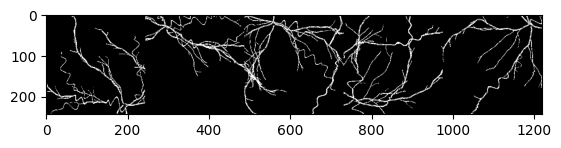

In [11]:
plt.imshow(np.hstack(images))

In [12]:
cropped_regions_batch = get_cropped_images(images, MIN_THRESHOLD, MAX_THRESHOLD)

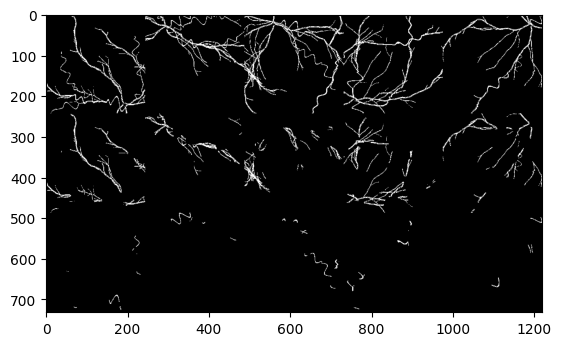

In [13]:
plt.imshow(np.hstack([np.vstack([img] + cropped_regions) for img, cropped_regions in zip(images, cropped_regions_batch)]))

In [14]:
skeletons_batch = []
for cropped_regions in cropped_regions_batch:
    skeletons = []
    discard = False
    for crop in cropped_regions:
        # Sometimes there are problems with skeleton analysis
        # indptr problems -> not solvable
        try:
            crop = crop[:, :, 0]
            # closed_crop = morphology.closing(crop, footprint=square(3))
            dilated_crop = morphology.dilation(crop, square(5))
            closed_crop = morphology.erosion(dilated_crop, square(3))
            skeletonized_crop = morphology.skeletonize(closed_crop)
            skeleton = Skeleton(skeletonized_crop)
            skeletons.append(skeleton)
        except Exception as e:
            print(e)
            print("Error in skeleton analysis. Discarding image.")
            discard = True
    if not discard:
        skeletons_batch.append(skeletons)

In [15]:
branch_data_batch = [
    [summarize(skeleton) for skeleton in skeletons]
    for skeletons in skeletons_batch
]

<Axes: >

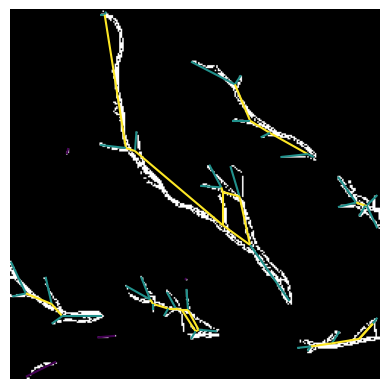

In [16]:
draw.overlay_euclidean_skeleton_2d(cropped_regions_batch[0][0], branch_data_batch[0][0])

In [17]:
branch_data_batch_filtered = [
    [filter_branch_lengthwise(branch_data, min_length=MIN_LENGTH) for branch_data in branch_data_img]
    for branch_data_img in branch_data_batch
]

<Axes: >

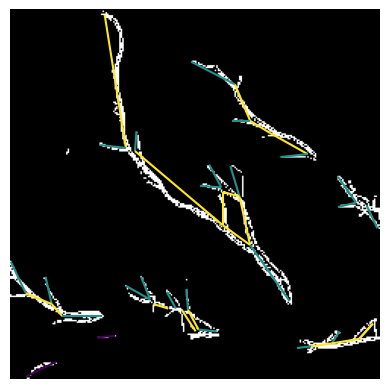

In [18]:
draw.overlay_euclidean_skeleton_2d(cropped_regions_batch[0][0], branch_data_batch_filtered[0][0])

In [19]:
tortuousity_data_batch = [
    [get_tortuousity_measure_branch_wise(branch_data) for branch_data in branch_data_img]
    for branch_data_img in branch_data_batch_filtered
]

### Mean

In [20]:
cnt = 0
for i, tortuousity_data_img in enumerate(tortuousity_data_batch):
    min_mean = tortuousity_data_img[0].mean()
    min_std = tortuousity_data_img[0].std()

    max_mean = tortuousity_data_img[1].mean()
    max_std = tortuousity_data_img[1].std()

    # print(min_mean, max_mean, min_std, max_std, sep="\t")

    if np.isnan(min_mean) or min_mean < max_mean:
        cnt += 1
    else:
        print(i)


print("Accuracy: ", cnt / N)

3
Accuracy:  0.8


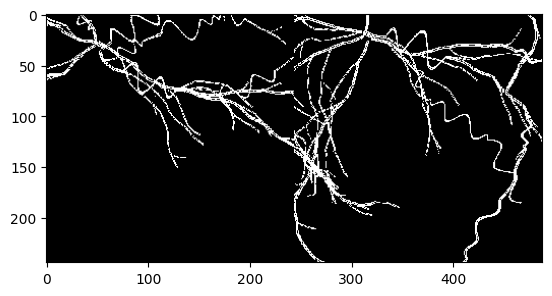

In [21]:
idxs = [1, 2]
imgs = [images[i] for i in idxs]
plt.imshow(np.hstack(imgs))

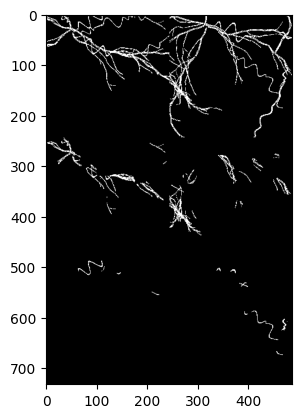

In [22]:
cropped_regions_idxs = [cropped_regions_batch[i] for i in idxs]
plt.imshow(np.hstack([np.vstack([img] + cropped_regions) for img, cropped_regions in zip(imgs, cropped_regions_idxs)]))

In [23]:
idx = idxs[0]

<Axes: >

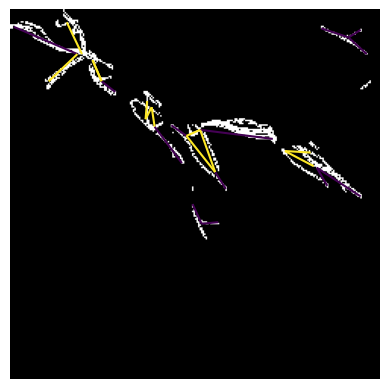

In [24]:
draw.overlay_euclidean_skeleton_2d(cropped_regions_idxs[0][0], branch_data_batch_filtered[idxs[0]][0])

<Axes: >

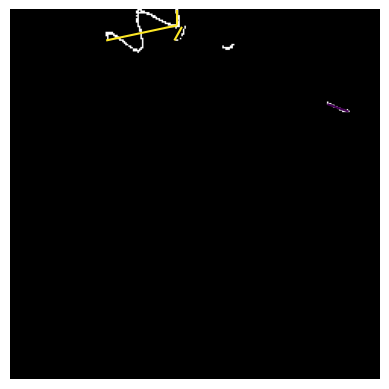

In [25]:
draw.overlay_euclidean_skeleton_2d(cropped_regions_idxs[0][1], branch_data_batch_filtered[idxs[0]][1])

### Top k

In [26]:
k = 5
cnt = 0
for tortuousity_data_img in tortuousity_data_batch:
    min_mean = tortuousity_data_img[0].nlargest(k).mean()
    min_std = tortuousity_data_img[0].nlargest(k).std()

    max_mean = tortuousity_data_img[1].nlargest(k).mean()
    max_std = tortuousity_data_img[1].nlargest(k).std()

    # print(min_mean, max_mean, min_std, max_std, sep="\t")

    if np.isnan(min_mean) or min_mean < max_mean:
        cnt += 1

print("Accuracy (top k): ", cnt / N)

Accuracy (top k):  0.2


### Quantile = 0.75

In [27]:
k = 5
cnt = 0
for tortuousity_data_img in tortuousity_data_batch:
    min_mean = tortuousity_data_img[0].quantile(0.75)
    min_std = tortuousity_data_img[0].std()

    max_mean = tortuousity_data_img[1].quantile(0.75)
    max_std = tortuousity_data_img[1].nlargest(k).std()

    # print(min_mean, max_mean, min_std, max_std, sep="\t")

    if np.isnan(min_mean) or min_mean < max_mean:
        cnt += 1

print("Accuracy (top k): ", cnt / N)

Accuracy (top k):  1.0


### Quantile = 0.5

In [28]:
k = 5
cnt = 0
for tortuousity_data_img in tortuousity_data_batch:
    min_mean = tortuousity_data_img[0].quantile(0.5)
    min_std = tortuousity_data_img[0].std()

    max_mean = tortuousity_data_img[1].quantile(0.5)
    max_std = tortuousity_data_img[1].nlargest(k).std()

    # print(min_mean, max_mean, min_std, max_std, sep="\t")

    if np.isnan(min_mean) or min_mean < max_mean:
        cnt += 1

print("Accuracy (top k): ", cnt / N)

Accuracy (top k):  1.0
